## Stochastic Wind

_Exercises 6.9: Re-solve the windy gridworld task with King’s moves, assuming that the effect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column._


In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes

In [ ]:
class WindyGridworld(gym.Env):
    TARGET = np.array((3, 7))
    WIND_STRENGTH = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    MAX_TIMESTEP = 100
    _ACTION_TO_DELTA = {
        0: np.array((-1, 0)),
        1: np.array((0, 1)),
        2: np.array((1, 0)),
        3: np.array((0, -1)),
    }

    @staticmethod
    def _clamp(state):
        return np.clip(state, [0, 0], [6, 9])

    def __init__(self):
        super().__init__()
        self.observation_space = spaces.MultiDiscrete([7, 10])
        self.action_space = spaces.Discrete(4)
        self._state = None
        self._timestep = None

    def reset(self):
        self._state = np.array((3, 0))
        self._timestep = 0
        return self._state, {"timestep": 0}

    def step(self, action):
        wind = np.array((-self.WIND_STRENGTH[self._state[1]], 0))
        delta = self._ACTION_TO_DELTA[action]
        self._state = self._clamp(self._state + wind + delta)

        self._timestep += 1
        reward = -1
        terminated = np.array_equal(self._state, self.TARGET)
        truncated = self._timestep >= self.MAX_TIMESTEP

        return self._state, reward, terminated, truncated, {"timestep": self._timestep}

In [4]:
class KingsGridworld(WindyGridworld):
    _ACTION_TO_DELTA = {
        0: np.array((-1, 0)),
        1: np.array((-1, 1)),
        2: np.array((0, 1)),
        3: np.array((1, 1)),
        4: np.array((1, 0)),
        5: np.array((1, -1)),
        6: np.array((0, -1)),
        7: np.array((-1, -1)),
        8: np.array((0, 0)),
    }

    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(9)

In [41]:
class StochasticGridworld(KingsGridworld):
    def step(self, action):
        wind = np.array((-self.WIND_STRENGTH[self._state[1]], 0))
        if wind[0] != 0:
            wind[0] += np.random.choice([-1, 0, 1])
        delta = self._ACTION_TO_DELTA[action]
        self._state = self._clamp(self._state + wind + delta)

        self._timestep += 1
        reward = -1
        terminated = np.array_equal(self._state, self.TARGET)
        truncated = self._timestep >= self.MAX_TIMESTEP

        return self._state, reward, terminated, truncated, {"timestep": self._timestep}

In [201]:
# This is the best set of hyperparameters I found
epsilon = 0.1
epsilon_final = 0.005
epsilon_half_life = 30

alpha = 0.5
alpha_final = 0.01
alpha_half_life = 1000

gamma = 1
training_t = 40000

epsilon_decay = 0.5 ** (1 / epsilon_half_life)
alpha_decay = 0.5 ** (1 / alpha_half_life)

q = np.zeros((7, 10, 9))


def epsilon_greedy(s):
    if np.random.rand() < epsilon:
        return np.random.choice(range(9))
    i, j = s
    return np.argmax(q[i, j])


env = StochasticGridworld()

total_t = 0
ep_timesteps = []
while total_t < training_t:
    s, _ = env.reset()
    a = epsilon_greedy(s)
    done = False
    while not done:
        s_prime, r, terminated, truncated, info = env.step(a)
        a_prime = epsilon_greedy(s_prime)

        td_error = r + gamma * q[tuple(s_prime) + (a_prime,)] - q[tuple(s) + (a,)]
        q[tuple(s) + (a,)] += alpha * td_error

        s = s_prime
        a = a_prime
        done = terminated or truncated
    ep_timesteps.append(info["timestep"])
    total_t += info["timestep"]
    alpha = max(alpha_final, alpha * alpha_decay)
    epsilon = max(epsilon_final, epsilon * epsilon_decay)

greedy_pi = np.argmax(q, axis=2)
greedy_pi[tuple(WindyGridworld.TARGET)] = -1

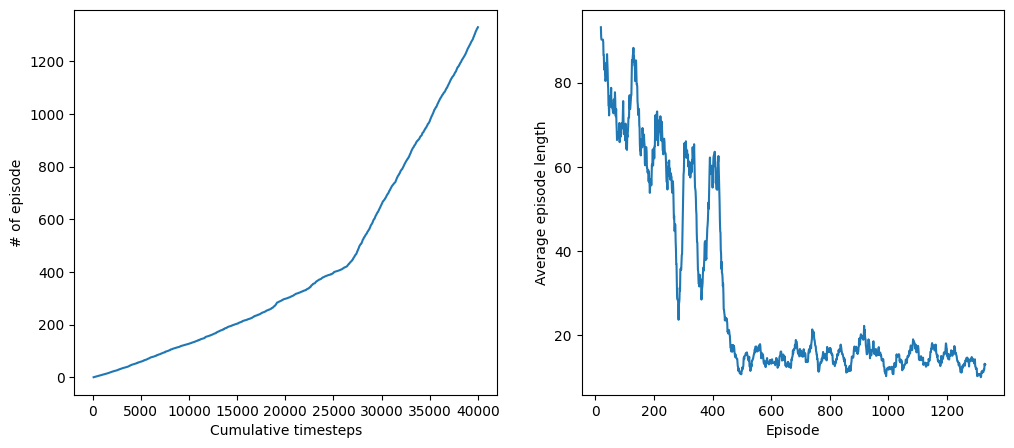

In [202]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = axs
ax1: Axes
ax2: Axes

ax1.plot(np.cumsum(ep_timesteps), range(len(ep_timesteps)))
ax1.set_xlabel("Cumulative timesteps")
ax1.set_ylabel("# of episode")

window_size = 20
kernel = np.ones(window_size) / window_size
rolling_steps = np.convolve(ep_timesteps, kernel, mode="valid")
ax2.plot(range(window_size - 1, len(ep_timesteps)), rolling_steps)
ax2.set_xlabel("Episode")
ax2.set_ylabel("Average episode length")
# ax2.set_yticks([7] + [*range(20, WindyGridworld.MAX_TIMESTEP, 10)])

plt.show()

In [203]:
# ep_timesteps
ep_timesteps[:10], ep_timesteps[-15:]
# epsilon
# alpha

([100, 100, 100, 100, 100, 100, 100, 100, 94, 100],
 [9, 29, 7, 15, 7, 15, 8, 8, 24, 19, 7, 14, 32, 9, 9])

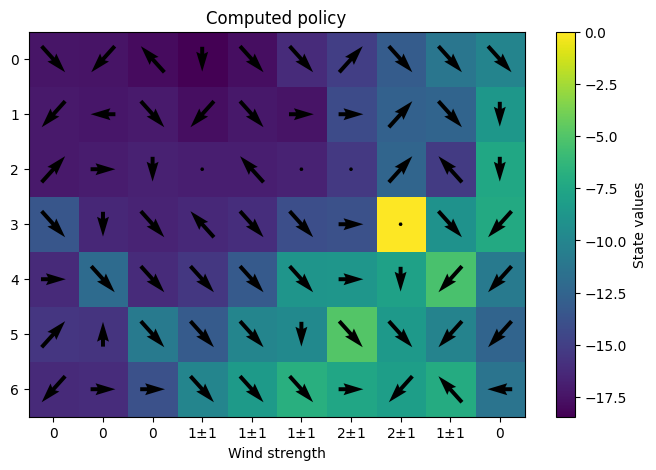

In [204]:
fig, ax = plt.subplots(figsize=(8, 5))
ax: Axes

im = ax.imshow(np.max(q, axis=2), cmap="viridis", aspect="auto")
ax.set_xticks(
    range(10),
    labels=[
        str(s) + ("$\pm$1" if s > 0 else "") for s in StochasticGridworld.WIND_STRENGTH
    ],
)
ax.set_xlabel("Wind strength")
# ax.set_yticks(range(7), labels=[""] * 7)

x, y = np.meshgrid(range(10), range(7))
u = np.zeros_like(greedy_pi)
v = np.zeros_like(greedy_pi)
for i in range(7):
    for j in range(10):
        u[i, j] = (
            1 if 1 <= greedy_pi[i, j] <= 3 else -1 if 5 <= greedy_pi[i, j] <= 7 else 0
        )
        v[i, j] = (
            1
            if 3 <= greedy_pi[i, j] <= 5
            else -1 if (greedy_pi[i, j] in [7, 0, 1]) else 0
        )
ax.quiver(x, y, u, v, color="k", angles="xy", scale=20, width=0.008, pivot="middle")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("State values")

ax.set_title("Computed policy")

plt.show()

In [205]:
q[3, 0]

array([-17.71970695, -17.71061924, -17.53021121, -13.49781361,
       -17.57795159, -17.4951617 , -17.63440658, -17.66893561,
       -18.01041236])